# Simulate acoustic wave propagation through nested geometries

The OptimUS library provides acoustic wave simulations with the boundary element method (BEM) for a general class of geometries. The three-dimensional space can be, e.g., multiple disjoint scatterers are nested domains. More generally, the library works for piecewise constant subdomains. That is, each subdomain has constant material parameters, such as density, speed of sound, and attenuation. An arbitrary number of materials can be used, as disjoint domains, inside another domain, or any combination. The only restriction is that no junctions of three or more elements are present. This notebook demonstrates the flexible creation of a nested geometry.

In [1]:
# Import development version of OptimUS
%matplotlib inline
import sys
sys.path.append('..')
import optimus

In [2]:
print(optimus.__version__)

0.2.0


## Specify the material and wave parameters

Let us use a standard incident wave field, given by a plane wave with a given direction and frequency.

In [3]:
frequency = 150e3

In [4]:
source = optimus.source.create_planewave(frequency, direction=(1,0,0))

We like to create a geometry where the unbounded exterior domain is water and where three materials are present, with parameters for fat, corticial bone and air. Let us use the built-in materials database of OptimUS to retrieve the acoustic parameters.

In [5]:
material_ext = optimus.material.load_material('water')
material1, material2, material3 = optimus.material.load_material(('fat', 'bone (cortical)', 'air'))

## Create the geometries

Let us now create the model geometry. In this tutorial, we like to create a model with three spheres, where the second and third are located inside the first. The spheres have different radii and are located at different positions. We like to use a mesh width of 4 points per wavelength (ppwl) for the smallest wavelength across the material interfaces.

The first step is to compute the wavelength in each material and specify the number of points per wavelength for the mesh. Notice that this parameter can be different for each mesh, if necessary.

In [6]:
print("The frequency is %.2f kHz." %(frequency/1e3))
wavelengths = []
for material in [material_ext, material1, material2, material3]:
    wavelengths.append(material.compute_wavelength(frequency))
    print("The wavelength in " + material.name + " is %.2f mm." %(wavelengths[-1]*1e3))

The frequency is 150.00 kHz.
The wavelength in water is 9.88 mm.
The wavelength in fat is 9.60 mm.
The wavelength in bone (cortical) is 23.43 mm.
The wavelength in air is 2.29 mm.


In [7]:
ppwl = 4
print("The number of points per wavelength is %d." %ppwl)

The number of points per wavelength is 4.


The geometry consists of multiple nested domains. This can conveniently be represented by a graph topology. Let us create a graph geometry and give it a label.

In [8]:
mygraph = optimus.geometry.Graph("three_nested_scatterers")

First, we need to specify the unbounded exterior domain, which will consist of water and also has the plane-wave incident wave field.

In [9]:
mygraph.create_exterior_domain(material_ext, source)

Let us create the first sphere with a radius of 10 mm and located at the origin. The mesh width is set to the smallest wavelength across the interfaces divided by 4, where we take water in the exterior domain and fat in the interior domain.


In [10]:
meshwidth1 = min(wavelengths[0], wavelengths[1]) / ppwl
geometry1 = optimus.geometry.shapes.Sphere(radius=10e-3, origin=(0,0,0), element_size=meshwidth1, label="sphere1")
print("The first interface is a %s and has a mesh width of %.2f mm." %(geometry1.shape, meshwidth1*1e3))

The first interface is a sphere and has a mesh width of 2.40 mm.


To add this material to the model, we need to create a new interface in the graph topology. For this, specify the geometry, the label of the subdomain in which to locate the new interface, and the material interior to the interface.

In [11]:
mygraph.create_interface(geometry1, 0, material1, verbose=True)

Created new subdomain node 1.
Created new interface node 1.
Updated topology of exterior subdomain node 0.
Updated topology of exterior interface node 0.
Created new edge 0.
Created new edge 1.
Created new self-exterior interface connector 0.
Created new self-interior interface connector 1.


The second and third sphere will be located inside the first sphere, one next to the other, without touching. Specifically, the second sphere has a radius of 4 mm and it's origin is shifted 4 mm to the left. The third sphere has a radius of 2 mm and is shifted 4 mm to the right of the global origin.

First, we calculate the mesh width for the second and third sphere based on the smallest wavelength across the interfaces. Then, we create the geometries and add them to the graph topology.

In [12]:
meshwidth2 = min(wavelengths[1], wavelengths[2]) / ppwl
meshwidth3 = min(wavelengths[1], wavelengths[3]) / ppwl

geometry2 = optimus.geometry.shapes.Sphere(radius=4e-3, origin=(-4e-3,0,0), element_size=meshwidth2, label="sphere2")
geometry3 = optimus.geometry.shapes.Sphere(radius=2e-3, origin=(4e-3,0,0), element_size=meshwidth3, label="sphere3")

print("The second interface is a %s and has a mesh width of %.2f mm." %(geometry2.shape, meshwidth2*1e3))
print("The third interface is a %s and has a mesh width of %.2f mm." %(geometry3.shape, meshwidth3*1e3))

The second interface is a sphere and has a mesh width of 2.40 mm.
The third interface is a sphere and has a mesh width of 0.57 mm.


Now, we add the second and third sphere to the graph topology. Notice that the label for the *exterior* domain is now 1 since we locate the spheres inside the first sphere.

In [13]:
mygraph.create_interface(geometry2, 1, material2, verbose=True)
mygraph.create_interface(geometry3, 1, material3, verbose=True)

Created new subdomain node 2.
Created new interface node 2.
Updated topology of exterior subdomain node 1.
Updated topology of exterior interface node 1.
Created new edge 2.
Created new edge 3.
Created new self-exterior interface connector 2.
Created new self-interior interface connector 3.
Created new parent-child interface connector 4.
Created new subdomain node 3.
Created new interface node 3.
Updated topology of exterior subdomain node 1.
Updated topology of exterior interface node 1.
Updated topology of sibling interface node 2.
Created new edge 4.
Created new edge 5.
Created new self-exterior interface connector 5.
Created new self-interior interface connector 6.
Created new parent-child interface connector 7.
Created new sibling interface connector 8.


The graph topology is now complete. Let us print some information about the graph.

In [14]:
mygraph.print_graph_information()

Label of graph: three_nested_scatterers
Number of subdomain nodes: 4
Number of interface nodes: 4
Number of edges: 6
Number of interface connectors: 9

Topology of subdomain nodes:
 Subdomain node 0:
  Parent interface: 0
  Child interfaces: [1]
  Bounded: False
 Subdomain node 1:
  Parent interface: 1
  Child interfaces: [2, 3]
  Bounded: True
 Subdomain node 2:
  Parent interface: 2
  Child interfaces: []
  Bounded: True
 Subdomain node 3:
  Parent interface: 3
  Child interfaces: []
  Bounded: True

Topology of interface nodes:
 Interface node 0:
  Parent subdomain: None
  Child subdomain: 0
  Parent interface: None
  Sibling interfaces: []
  Child interfaces: [1]
  Bounded: False
 Interface node 1:
  Parent subdomain: 0
  Child subdomain: 1
  Parent interface: 0
  Sibling interfaces: []
  Child interfaces: [2, 3]
  Bounded: True
 Interface node 2:
  Parent subdomain: 1
  Child subdomain: 2
  Parent interface: 1
  Sibling interfaces: [3]
  Child interfaces: []
  Bounded: True
 Inter

## Create the computational model

For most purposes, a default model can be created with the `optimus.model.create_nested_model(mygraph, frequency)` function. The OptimUS also allows to select specific boundary integral formulations and preconditioners. For example, we can use the PMCHWT formulation with the OSRC preconditioner for the largest interface and the mass preconditioner for the smaller interior domains.

In [15]:
model = optimus.model.create_nested_model(mygraph, frequency, "pmchwt", ["osrc","mass","mass"])

Before solving the model, we can check if the domains are correctly defined by visualising the computational grid on which we will calculate the pressure field. For this, we define a plane that intersects the nested spheres. Notice that this grid is for visualisation purposes only and does not affect the BEM solution.

In [16]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)

In [17]:
postprocess_plane.create_computational_grid(resolution=(80, 60), bounding_box=(-20e-3, 20e-3, -15e-3, 15e-3))

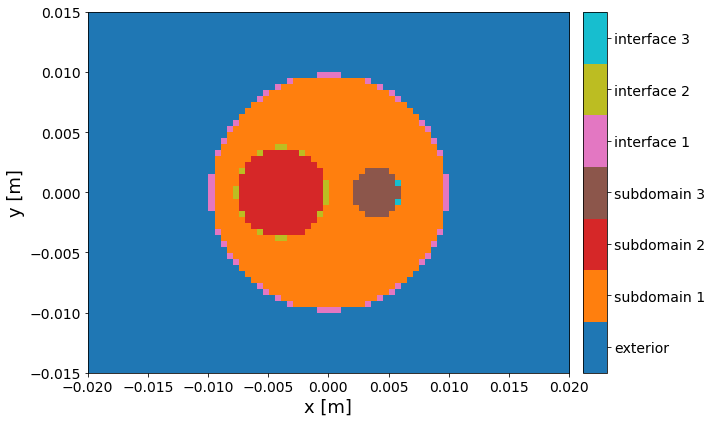

In [18]:
fig = optimus.postprocess.plot_regions(postprocess_plane)

We con now solve the BEM model. Depending on the grid resolution this may take long computation times.

In [19]:
%%time
model.solve()

CPU times: user 1min 13s, sys: 35.5 s, total: 1min 48s
Wall time: 12.9 s


inally, we can calculate the pressure field on the plane and visualise the results.

In [20]:
%%time
postprocess_plane.compute_fields()

CPU times: user 18.1 s, sys: 1.59 s, total: 19.7 s
Wall time: 2.15 s


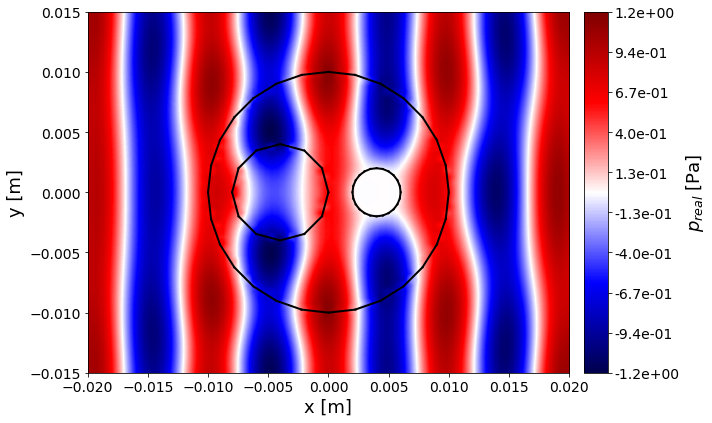

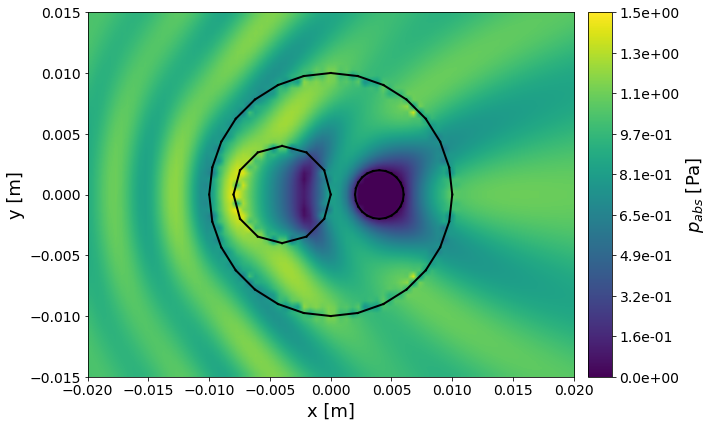

In [21]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane)